In [2]:
import pandas as pd
from io import StringIO
import re
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../datasets/analysis_memory_usage.csv")
print(len(df), "rows")

16 rows


In [4]:
relevant_cols = [
    "run_name",
    "Runtime",
    "bf16",
    "fp16",
    "gradient_accumulation_steps",
    "gradient_checkpointing",
    "gradient_checkpointing_kwargs.use_reentrant",
    "quantization_config._load_in_4bit",
    "quantization_config._load_in_8bit",
    "quantization_config.bnb_4bit_compute_dtype",
    "quantization_config.bnb_4bit_quant_type",
    "quantization_config.bnb_4bit_use_double_quant",
    "quantization_config.quant_method",
    "per_device_train_batch_size",
    "memory_used_bytes",
]

df_memory = df[relevant_cols]

def fix_gradient_checkpointing(df: pd.DataFrame):
    df['gradient_checkpointing'] = df['run_name'].map(lambda x: bool(int(re.search(r"-gc(\d)-", x).groups()[0])))

def extract_context_length(df: pd.DataFrame):
    df['context_length'] = df['run_name'].map(lambda x: int(re.search(r"-ctx(\d+)-", x).groups()[0]))

def from_bytes_to_gigas(df: pd.DataFrame):
    df['memory_used_gigas'] = df['memory_used_bytes'].map(lambda x: x / 1024**3)

fix_gradient_checkpointing(df_memory)
extract_context_length(df_memory)
from_bytes_to_gigas(df_memory)
df_memory.head()

/tmp/ipykernel_26430/358789391.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gradient_checkpointing'] = df['run_name'].map(lambda x: bool(int(re.search(r"-gc(\d)-", x).groups()[0])))
/tmp/ipykernel_26430/358789391.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['context_length'] = df['run_name'].map(lambda x: int(re.search(r"-ctx(\d+)-", x).groups()[0]))
/tmp/ipykernel_26430/358789391.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,run_name,Runtime,bf16,fp16,gradient_accumulation_steps,gradient_checkpointing,gradient_checkpointing_kwargs.use_reentrant,quantization_config._load_in_4bit,quantization_config._load_in_8bit,quantization_config.bnb_4bit_compute_dtype,quantization_config.bnb_4bit_quant_type,quantization_config.bnb_4bit_use_double_quant,quantization_config.quant_method,per_device_train_batch_size,memory_used_bytes,context_length,memory_used_gigas
0,memory_ctx_test-Llama-2-7b-chat-hf_rv32-ld0-bs...,1728,True,False,4,False,NaN,True,False,bfloat16,nf4,True,QuantizationMethod.BITS_AND_BYTES,1,45548830720,4096,42.420654
1,memory_ctx_test-Mistral-7B-Instruct-v0.2_rv32-...,1936,True,False,4,False,NaN,True,False,bfloat16,nf4,True,QuantizationMethod.BITS_AND_BYTES,1,49415979008,4096,46.022217
2,memory_ctx_test-Llama-2-7b-chat-hf_rv32-ld0-bs...,1774,True,False,4,False,NaN,True,False,bfloat16,nf4,True,QuantizationMethod.BITS_AND_BYTES,1,35516055552,2048,33.076904
3,memory_ctx_test-Mistral-7B-Instruct-v0.2_rv32-...,1942,True,False,4,False,NaN,True,False,bfloat16,nf4,True,QuantizationMethod.BITS_AND_BYTES,1,36971479040,2048,34.432373
4,memory_ctx_test-Llama-2-7b-chat-hf_rv32-ld0-bs...,1704,True,False,4,False,NaN,True,False,bfloat16,nf4,True,QuantizationMethod.BITS_AND_BYTES,1,23633592320,1024,22.010498


In [5]:
mistral_data = df_memory.loc[df_memory.run_name.str.contains('mistral', case=False)]
llama_data = df_memory.loc[df_memory.run_name.str.contains('llama', case=False)]

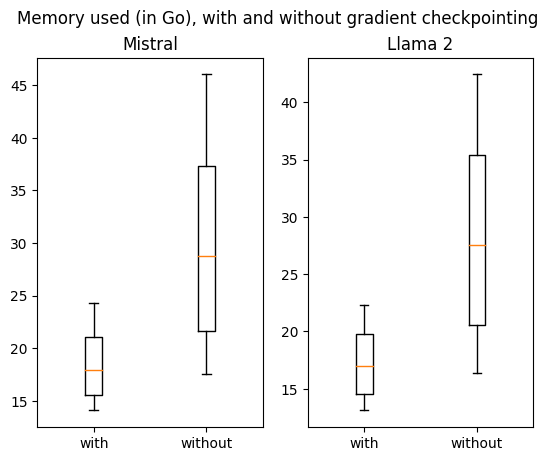

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
data_sep_gc_mistral = [
    mistral_data.loc[(mistral_data['gradient_checkpointing'] == True)].memory_used_gigas,
    mistral_data.loc[(mistral_data['gradient_checkpointing'] == False)].memory_used_gigas
    ]

data_sep_gc_llama = [
    llama_data.loc[(llama_data['gradient_checkpointing'] == True)].memory_used_gigas,
    llama_data.loc[(llama_data['gradient_checkpointing'] == False)].memory_used_gigas
    ]
labels = ["with", "without"]
ax1.boxplot(x=data_sep_gc_mistral, labels=labels)
ax1.set_title("Mistral")

ax2.boxplot(x=data_sep_gc_llama, labels=labels)
ax2.set_title("Llama 2")
fig.suptitle('Memory used (in Go), with and without gradient checkpointing')
plt.show()

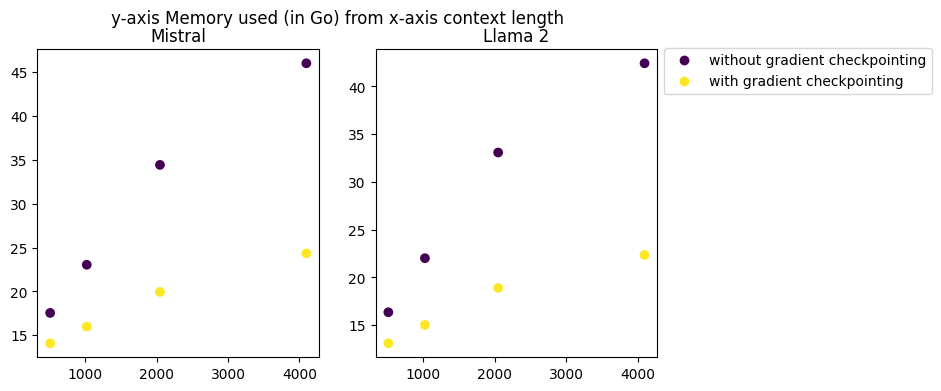

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

ax1.scatter(x=mistral_data.context_length, y=mistral_data.memory_used_gigas, c=mistral_data.gradient_checkpointing)
ax1.set_title("Mistral")

scatter = ax2.scatter(x=llama_data.context_length, y=llama_data.memory_used_gigas, c=llama_data.gradient_checkpointing)
ax2.set_title("Llama 2")
fig.suptitle('y-axis Memory used (in Go) from x-axis context length')
fig.legend(
    handles=scatter.legend_elements()[0],
    labels=["without gradient checkpointing", "with gradient checkpointing"],
    loc="upper left",
    bbox_to_anchor=(0.9, 0.9)
    )
plt.show()

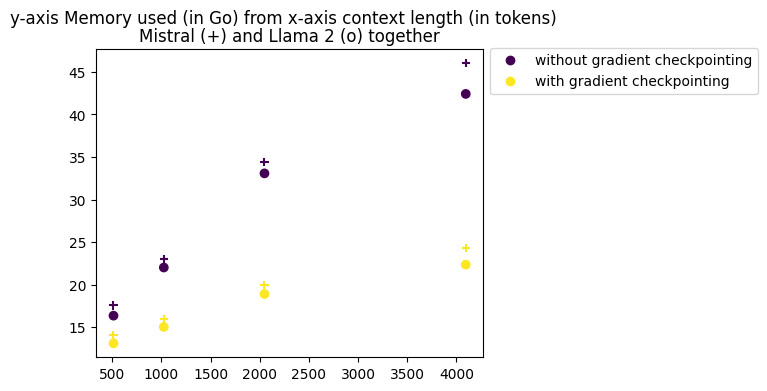

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 4)

scatter = ax.scatter(
    x=mistral_data.context_length,
    y=mistral_data.memory_used_gigas,
    c=mistral_data.gradient_checkpointing,
    marker="+"
    )
scatter = ax.scatter(
    x=llama_data.context_length,
    y=llama_data.memory_used_gigas,
    c=llama_data.gradient_checkpointing,
    marker="o"
    )
ax.set_title("Mistral (+) and Llama 2 (o) together")

fig.suptitle('y-axis Memory used (in Go) from x-axis context length (in tokens)')
fig.legend(
    handles=scatter.legend_elements()[0],
    labels=["without gradient checkpointing", "with gradient checkpointing"],
    loc="upper left",
    bbox_to_anchor=(0.9, 0.9)
    )
plt.show()